In [1]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

workspace_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/SEPT10'
#workspace_dir  = '/scr/malta3/workspace/project_iron/phenotypic'
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
mrs_dir        = os.path.join(workspace_dir, 'DF_MRS')

qc_outliers_c  = []#['GSAT', 'TR4T'] 
qc_outliers_p  = [  #Spatial 'LA9P',
                  'NL2P', 'HSPP', 'STDP', 'DF2P'# Chi 
                 ]

/Users/kanaan/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
controls_matched = [ 'GSNT', 'TJ5T', 'PAHT', 'LMIT', 'RMNT', 'MJBT', 'SDCT', 'TR4T', 'TV1T', 'RJJT',
                     'HM1X', 'STQT', 'SS1X', 'LL5T', 'PU2T', 'BH5T', 'SMVX', 'GSAT', 'EC9T', 'RA7T',
                     'KO4T', 'HM2X', 'GHAT', 'FA2T', 'SC1T', 'WSKT'] 

In [3]:
def get_dfs(popname,drop):
    df_qsm = pd.read_csv(os.path.join(pheno_dir, 'df_raw_%s.csv'%popname),index_col = 0).sort_values('Age')
    df_cln = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s.csv'%popname), index_col=0)
    df_cln.columns = ['CLN_' + str(col) for col in df_cln.columns]   
        
    
    if popname == 'controls':
        for subject in df_cln.index:
            df_cln.ix[subject, 'Diagnosis'] = 'HC'
            
    if popname == 'patients':
        for subject in df_cln.index:
            adhd    = df_cln.loc[subject]['CLN_Diag_ADHD'].astype(int)
            ocd     = df_cln.loc[subject]['CLN_Diag_OCD'].astype(int)
            depr    = df_cln.loc[subject]['CLN_Diag_Depression'].astype(int)
            anx     = df_cln.loc[subject]['CLN_Diag_Anxiety'].astype(int)

            if ocd == 1 and adhd == 1:
                df_cln.ix[subject, 'Diagnosis'] = 'GTS_OCD_ADHD'
            elif ocd == 1  and adhd == 0:
                df_cln.ix[subject, 'Diagnosis'] = 'GTS_OCD'
            elif ocd == 0 and adhd == 1:
                df_cln.ix[subject, 'Diagnosis'] = 'GTS_ADHD'
            elif ocd == 0and adhd == 0:
                df_cln.ix[subject, 'Diagnosis'] = 'GTS'
    
    
    def get_mrs_df(vox, popname):
        df_mrs = pd.read_csv(os.path.join(mrs_dir, 'moco_df_%s_%s_a.csv'%(vox, popname)),index_col = 0)
        df_mrs.columns = ['%s_'%vox + str(col) for col in df_mrs.columns]
        return df_mrs 
    
    df = pd.concat([df_qsm, 
                    df_cln, 
                    get_mrs_df('STR', popname),
                    get_mrs_df('THA', popname),
                    get_mrs_df('ACC', popname)], axis=1, join_axes=[df_qsm.index]).drop(drop,axis=0)
    
    df.sort_values('Age').to_csv(os.path.join(pheno_dir, 'df_%s_qc.csv'%popname))
    return df

df_controls = get_dfs('controls',qc_outliers_c)
df_patients = get_dfs('patients',qc_outliers_p)


/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [4]:
print 'Total Controls = ', len(df_controls.index)
print 'Total Patients = ', len(df_patients)

Total Controls =  26
Total Patients =  23


In [5]:
def cohen_d(df1,df2, metabolite):
        # Cohens D 
        from numpy import mean, std # version >= 1.7.1 && <= 1.9.1
        from math import sqrt
        import sys
        x = df1[metabolite].dropna(axis=0)
        y = df2[metabolite].dropna(axis=0)
        return (mean(x) - mean(y)) / sqrt((std(x, ddof=1) ** 2 + std(y, ddof=1) ** 2) / 2.0)

def get_gender_len(df):    
    males   = [subject for subject in df.index if df.loc[subject]['Gender'] == 0]
    females = [subject for subject in df.index if df.loc[subject]['Gender'] == 1]
    return len(males), len(females)

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 
    
    
def get_gender_len(df):    
    males   = [subject for subject in df.index if df.loc[subject]['Gender'] == 0]
    females = [subject for subject in df.index if df.loc[subject]['Gender'] == 1]
    return len(males), len(females)

def get_gender_age_stats(df1, df2):
    
    gender = pd.DataFrame(index =['Controls', 'Patients'], columns = ['Male', 'Female'])

    gender.ix['Controls'][0] = get_gender_len(df1)[0]
    gender.ix['Controls'][1] = get_gender_len(df1)[1]
    gender.ix['Patients'][0] = get_gender_len(df2)[0]
    gender.ix['Patients'][1] = get_gender_len(df2)[1]

    print '--------------- Gender ---------------'
    print gender
    print ''
    print 'FISCHER EXACT TEST:', 'Odds Ratio=',np.round(fisher_exact(gender)[0],2), 'P-Value=',np.round(fisher_exact(gender)[1],2)
    print ''
    print '--------------- Age ---------------'
    print 'Controls Age = ', np.round(np.mean(df1.Age),2), '±', np.round(np.std(df1.Age),2)
    print 'Patients Age = ', np.round(np.mean(df2.Age),2), '±', np.round(np.std(df2.Age),2)
    print 'T-TEST(%s) ='%(len(df1.index)+len(df2.index)-2), ttest_ind(df1.Age.dropna(), df2.Age.dropna()) 
    
get_gender_age_stats(df_controls, df_patients)

--------------- Gender ---------------
         Male Female
Controls   17      9
Patients   18      5

FISCHER EXACT TEST: Odds Ratio= 0.52 P-Value= 0.36

--------------- Age ---------------
Controls Age =  37.92 ± 11.82
Patients Age =  36.65 ± 10.78
T-TEST(47) = Ttest_indResult(statistic=0.38332677492299855, pvalue=0.703205927944135)


/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [6]:
26+23-2

47

/Users/kanaan/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


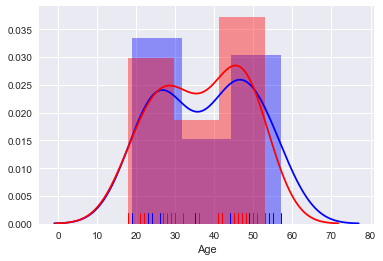

In [7]:
sns.distplot(df_controls.Age, color='b', rug=1 )
sns.distplot(df_patients.Age, color='r', rug=1 )


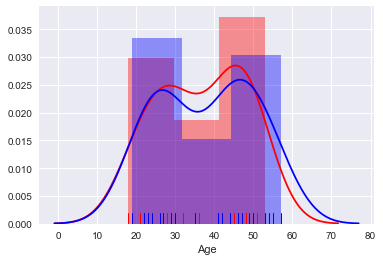

In [8]:
sns.distplot(df_patients.Age, color='r', rug=1 )
sns.distplot(df_controls.Age, color='b', rug=1 )


In [9]:
cln_metrics = ['CLN_YGTSS_Total_Tic_Score',
               'CLN_YGTSS_Total_Score_incl_Impairment',
               'CLN_YGTSS_Motoric_Score',
               'CLN_YGTSS_Vocal_Score',#, 
               'CLN_RVTRS',
               'CLN_puts',
               'CLN_YBOCS_Totalscore_Items_1to10', 
               'CLN_OCIR_total_score',
               'CLN_DSM4_ADHD_Score',
               'CLN_BDI12', 
               'CLN_BAI', 
               'CLN_MADRS',
              ]

for cln in cln_metrics:
    
    print '######################################'
    print cln[4:]
    C= df_controls[cln].dropna()
    P= df_patients[cln].dropna()
    ttest = ttest_ind(C,P, equal_var=0)
    print 'controls =', np.mean(C), np.std(C)
    print 'patients =', np.mean(P), np.std(P)
    print  't%s='%len(C+P-2),np.round(ttest[0],3) , 'p=',np.round(ttest[1],5)

######################################
YGTSS_Total_Tic_Score
controls = 0.0 0.0
patients = 19.9130434783 8.64222718616
t46= -10.807 p= 0.0
######################################
YGTSS_Total_Score_incl_Impairment
controls = 0.0 0.0
patients = 41.8260869565 17.3371984445
t46= -11.316 p= 0.0
######################################
YGTSS_Motoric_Score
controls = 0.0 0.0
patients = 12.9565217391 4.14391393302
t46= -14.665 p= 0.0
######################################
YGTSS_Vocal_Score
controls = 0.0 0.0
patients = 6.95652173913 5.90856607978
t46= -5.522 p= 2e-05
######################################
RVTRS
controls = 0.0 0.0
patients = 8.08695652174 4.51964834606
t46= -8.393 p= 0.0
######################################
puts
controls = 0.0 0.0
patients = 18.9130434783 5.83030347095
t46= -15.215 p= 0.0
######################################
YBOCS_Totalscore_Items_1to10
controls = 0.0 0.0
patients = 1.39130434783 3.3066353638
t46= -1.974 p= 0.06112
######################################
OCIR_t

In [10]:
C = df_controls.CLN_Ferritin.dropna()
P = df_patients.CLN_Ferritin.drop(['SA5U'],axis =0).dropna()
ttest = ttest_ind(C,P, equal_var=0)
#ttest = mannwhitneyu(C,P)
print ttest
print 'controls =', np.mean(C), np.std(C)
print 'patients =', np.mean(P), np.std(P)
print  't%s='%(len(C)+len(P)-2),np.round(ttest[0],3) , 'p=',np.round(ttest[1],5)

Ttest_indResult(statistic=2.841376898389472, pvalue=0.009727435781744419)
controls = 196.204444444 151.255514839
patients = 85.5593333333 48.8708658223
t31= 2.841 p= 0.00973


In [11]:
C = df_controls.STR_Gln_Glu.drop(['STQT', 'RMNT'],axis=0).dropna()
P = df_patients.STR_Gln_Glu.drop(['SBQP'],axis=0).dropna()
ttest = mannwhitneyu(C,P)
print ttest
print 'controls =', np.mean(C), np.std(C)
print 'patients =', np.mean(P), np.std(P)
print  't%s='%len(C+P-2),np.round(ttest[0],3) , 'p=',np.round(ttest[1],5)

MannwhitneyuResult(statistic=109.0, pvalue=0.07966690840717433)
controls = 0.429513049584 0.173956428129
patients = 0.351586830379 0.140486436186
t35= 109.0 p= 0.07967


In [12]:
C = df_controls.THA_Gln_Glu.dropna()
P = df_patients.THA_Gln_Glu.drop(['TT3P'],axis=0).dropna()
ttest = mannwhitneyu(C,P)
print ttest
print 'controls =', np.mean(C), np.std(C)
print 'patients =', np.mean(P), np.std(P)
print  't%s='%len(C+P-2),np.round(ttest[0],3) , 'p=',np.round(ttest[1],5)

MannwhitneyuResult(statistic=149.0, pvalue=0.1275703129052515)
controls = 0.495933241138 0.143204821551
patients = 0.447706292633 0.146394848492
t39= 149.0 p= 0.12757


In [13]:
def make_bsl_demographic_table(dfc,dfp):
    cols = [#'N',
            #'Gender', 
            'CLN_YGTSS_Motoric_Score',
            'CLN_YGTSS_Vocal_Score',#, 
            'CLN_RVTRS',
            'CLN_puts',
            'CLN_qol_score', 
            'CLN_OCIR_total_score',
            'CLN_YBOCS_Totalscore_Items_1to10', 
            'CLN_DSM4_ADHD_Score',
            'CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score',
            'CLN_BDI12', 
            'CLN_MADRS',
            'CLN_BAI', 
            #'STR_Gln_Glu',  'THA_Gln_Glu', 'ACC_Gln_Glu', 
            'GTS_PURE', 'GTS_OCD','GTS_ADHD','GTS_OCD_ADHD'
            ]
    
    rows = [#'N' ,
            'Controls', 'Patients', 'DOF','t_val', 'p_val' #'Levene', 'KSC','KSP','D',
           ]
    dfs= pd.DataFrame(index = rows, columns=cols)
    
    for col in cols[:-4]:
        
        t_val, p_val = ttest_ind(dfc[col].dropna(), dfp[col].dropna())
        lvn          = levene(dfc[col].dropna(), dfp[col].dropna())
        ksc          = kstest(preprocessing.scale(dfc[col].dropna()), 'norm')
        ksp          = kstest(preprocessing.scale(dfp[col].dropna()), 'norm')
        #dfs.ix['N'][col]        = len(dfc.index), len(dfp.index)
        dfs.ix['Controls'][col] = '%s±%s' %(np.round(np.mean(dfc[col].dropna()),2), np.round(np.std(dfc[col].dropna()),2)  )
        dfs.ix['Patients'][col] = '%s±%s' %(np.round(np.mean(dfp[col].dropna()),2), np.round(np.std(dfp[col].dropna()),2)  )
        dfs.ix['DOF'][col]      =  len(dfc[col].dropna()) + len(dfp[col].dropna()) - 2
        dfs.ix['t_val'][col]    = np.round(t_val,2)
        dfs.ix['p_val'][col]    = np.round(p_val,6)
        #dfs.ix['D'][col]        = np.round(cohen_d(dfc,dfp, col),2)
        #dfs.ix['Levene'][col]   = np.round(lvn[1],2)
        #dfs.ix['KSC'][col]      = np.round(ksc[1],2)
        #dfs.ix['KSP'][col]      = np.round(ksp[1],2)
    
    dfs.ix['Patients']['GTS_PURE']  = len([subject for subject in dfp.index if dfp.loc[subject]['Diagnosis'] == 'GTS'])
    dfs.ix['Patients']['GTS_OCD']  = len([subject for subject in dfp.index if dfp.loc[subject]['Diagnosis'] == 'GTS_OCD'])  
    dfs.ix['Patients']['GTS_ADHD']  = len([subject for subject in dfp.index if dfp.loc[subject]['Diagnosis'] == 'GTS_ADHD'])
    dfs.ix['Patients']['GTS_OCD_ADHD']  = len([subject for subject in dfp.index if dfp.loc[subject]['Diagnosis'] == 'GTS_OCD_ADHD'])
    return dfs.T

make_bsl_demographic_table(df_controls, df_patients)

/Users/kanaan/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Controls,Patients,DOF,t_val,p_val
CLN_YGTSS_Motoric_Score,0.0±0.0,12.96±4.14,44,-14.67,0
CLN_YGTSS_Vocal_Score,0.0±0.0,6.96±5.91,44,-5.52,2e-06
CLN_RVTRS,0.0±0.0,8.09±4.52,44,-8.39,0
CLN_puts,0.0±0.0,18.91±5.83,44,-15.22,0
CLN_qol_score,0.0±0.0,29.7±20.75,44,-6.71,0
CLN_OCIR_total_score,5.74±5.97,14.22±12.45,44,-2.88,0.006118
CLN_YBOCS_Totalscore_Items_1to10,0.0±0.0,1.39±3.31,44,-1.97,0.054734
CLN_DSM4_ADHD_Score,1.17±1.93,6.7±5.25,44,-4.63,3.2e-05
CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score,39.27±7.53,50.24±12.16,41,-3.49,0.001174
CLN_BDI12,1.78±3.37,13.26±12.14,44,-4.27,0.000102


In [14]:
26+23-2

47

In [15]:
np.mean(df_patients.CLN_YGTSS_Motoric_Score)

12.956521739130435

In [16]:
df_controls.CLN_YGTSS_Motoric_Score

SMVX    0.0
SS1X    0.0
STQT    0.0
HM1X    0.0
TR4T    0.0
WSKT    NaN
FA2T    NaN
SC1T    NaN
GSNT    0.0
PAHT    0.0
LL5T    0.0
RJJT    0.0
KO4T    0.0
HM2X    0.0
SDCT    0.0
MJBT    0.0
EC9T    0.0
RA7T    0.0
GHAT    0.0
PU2T    0.0
TJ5T    0.0
BH5T    0.0
LMIT    0.0
GSAT    0.0
TV1T    0.0
RMNT    0.0
Name: CLN_YGTSS_Motoric_Score, dtype: float64